In [1]:
# import save_load as sl
# import preprocess_data as ppd
import torch
from torch import nn
from torch.utils.data import DataLoader
# from model import DnCNN
# from Dataset import Img_Dataset
import numpy as np 
import pathlib

# Importing utitility functions for training
from PT_files.model import DnCNN, DnCNN_B
from PT_files.Dataset import Img_Dataset, Large_Img_Dataset
import PT_files.preprocess_data as ppd
import PT_files.save_load as sl
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

Using cuda device


In [33]:
data_6k = sl.NERSC_load('test_data70-6000.npy')
model = DnCNN()
param_name = "2k_model_bs64_e200.pth"    
start_idx = 0
end_idx = 2000

samp_idx = 0
noise_data_2k = data_6k[0]

In [34]:
current_dir = pathlib.Path().resolve()
model_params_path = current_dir / 'Model_params'
assert model_params_path.exists()
model_path = model_params_path / param_name

# model = model()
model.to(device)
model.load_state_dict(torch.load(str(model_path)))
model.eval();
# telling pytorch this is for inference and not learning, so keeps the weights unchanged
with torch.no_grad():
    test_noise = torch.Tensor(noise_data_2k[samp_idx:samp_idx+1,:, start_idx:end_idx,start_idx:end_idx])
    test_noise = test_noise.to(device)
    
    torch.cuda.empty_cache()
    output = model(test_noise)
    resid_img = output.cpu().detach().numpy()

In [43]:
full = np.empty((1, 1, 6000,6000))
count = np.empty((1, 1, 6000,6000))

(1, 1, 6000, 6000)


In [42]:
resid_img.shape

(1, 1, 2000, 2000)

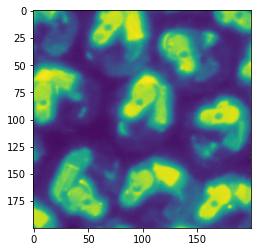

In [38]:
plt.imshow(resid_img[0][0][1800:2000,1800:2000])

In [53]:
def full_grid_pass_window(dataset,
                   model,
                   samp_idx,
                   w_start,
                   w_end,
                   h_start,
                   h_end):
    
    full = np.empty((1, 1, 6000,6000))
    count = np.empty((1, 1, 6000,6000))
    
    noise_data = dataset[0]
    param_name = "2k_model_bs64_e200.pth"
    
    current_dir = pathlib.Path().resolve()
    model_params_path = current_dir / 'Model_params'
    assert model_params_path.exists()
    model_path = model_params_path / param_name
    
    model = model()
    model.to(device)
    model.load_state_dict(torch.load(str(model_path)))
    model.eval();
    # telling pytorch this is for inference and not learning, so keeps the weights unchanged
    with torch.no_grad():
        test_noise = torch.Tensor(noise_data[samp_idx:samp_idx+1,:, w_start:w_end, h_start:h_end])
        test_noise = test_noise.to(device)

        torch.cuda.empty_cache()
        output = model(test_noise)
        resid_img = output.cpu().detach().numpy()
        
        full[:, :, w_start: w_end, h_start: h_end] += resid_img
        count[:, :, w_start: w_end, h_start: h_end] += 1
        
    return full, count

In [54]:
full, count = full_grid_pass_window(dataset=data_6k,
                             model= DnCNN,
                             samp_idx=0,
                             w_start=0,
                             w_end=2000,
                             h_start=0,
                             h_end=2000)

In [55]:
full.shape

(1, 1, 6000, 6000)

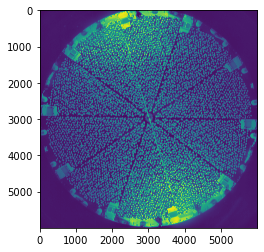

In [56]:
plt.imshow(data_6k[0][0][0][:,:])

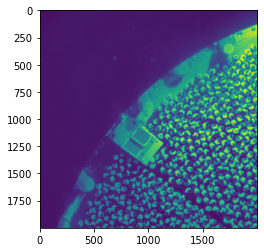

In [57]:
plt.imshow(data_6k[0][0][0][0:2000,0:2000])

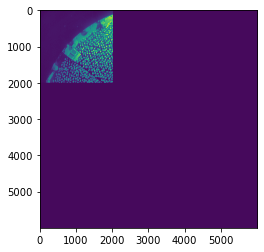

In [58]:
plt.imshow(full[0][0][:, :])

In [ ]:
def full_grid_pass(dataset,
                   model,
                   samp_idx,
                   w_start,
                   w_end,
                   h_start,
                   h_end):
    
    slice_list = [2000, 4000, 6000]
    
    for i in range(slice_list):
        for j in range(slice_list):
            full, count = full_grid_pass_window(dataset=data_6k,
                                     model= DnCNN,
                                     samp_idx=0,
                                     w_start=0,
                                     w_end=slice_list[j],
                                     h_start=0,
                                     h_end=2000)

In [ ]:
slice_list = [2000, 4000, 6000]
    
for i in range(slice_list):
    for j in range(slice_list):
        full, count = full_grid_pass_window(dataset=data_6k,
                                 model= DnCNN,
                                 samp_idx=0,
                                 w_start=0,
                                 w_end=slice_list[j],
                                 h_start=0,
                                 h_end=2000)

In [ ]:
def full_grid_pass(dataset,
                   model,
                   w_start_idx,
                   w_end_idx,
                   h_start_idx,
                   h_end_idx):
    
    """
    Conducts denoising in 2000x2000 sub-image slices of the whole 
    6000x6000 focal plane image. It implements the first of three
    passes of the image. It implements 9 inferences over the whole
    focal plane image and covers the entire image.
    
    
    
    Parameters:
    -----------
    
    dataset: np.array
        Should be a 5-D array of:
        
        dataset.shape = (dataset, number of samples, channel number,
                         number of pixels in width, number of pixels in height)
    
    
    model: pytorch model
        Should be DnCNN or DnCNN-B as proposed as in Zheng et al. 2017
        
    
    w_start_idx: int
        Starting index of the width of the subimage window
        
    w_end_idx: int
        Ending index of the width of the subimage window
        
    h_start_idx: int
        Starting index of the height of the subimage window
        
    h_end_idx: int
        Ending index of the height of the subimage window  
        
    Returns:
    --------
    
    full: np.array
        A (6000, 6000) array that contains all 9 of the (2000x2000) 
        sub-images combined together
        
        
    count: np.array
        An array that counts how many times an individual pixel has had
        a denoising window applied to it. This will be used to average
        over the pixels that are denoised multiple times.
    """